(maintenance-example)=
# Maintenance planning

This example is available in the following formats:

- YAML
    - [](model_maintenance.yaml)

## Introduction

Short-term hydro scheduling aims at determining the optimal generation schedules for the available hydro resources for the coming hours and days by utilizing the water potential in the most economical way. Maintenance, in general, is the activity to recover or keep a system in a functioning state. At present, the maintenance strategy is included in SHOP as pre-scheduled events. That is to say, the decision regarding which units in which stations at which time and for how long the units should be shut down for maintenance is given as time series input data. Whenever possible, the outages are planned at a time when they have the least impact on electricity production. This decision originates from the traditional corrective and preventive maintenance strategy.

In SHOP, maintenance can be given on the [](plant) level with the [maintenance_flag](plant:maintenance_flag) or on the [](generator) and [](pump) level with attributes also called maintenance_flag. If the flag is set to 1, it indicates that the plant or unit is under maintenance, and hence it is not available. If the flag is set to 0, the plant or unit functions as normal. 

Maintenance has the highest priority. Once a hydropower plant or a unit is under maintenance, it will not be included in the optimization model. Make sure that there are bypass or spill options so that water can bypass the plant under maintenance.

In this example, the cost of having a generator on maintenance will be calculated by running two SHOP models with and without maintenance. Multiple runs can be used to try to find the best period for maintenance, but is not shown in this example due to the computational burden.

## Model setup

In [1]:
# General introduction
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
from pyshop import ShopSession
import time
import math

Load in the fairly large model from YAML and show the topology:

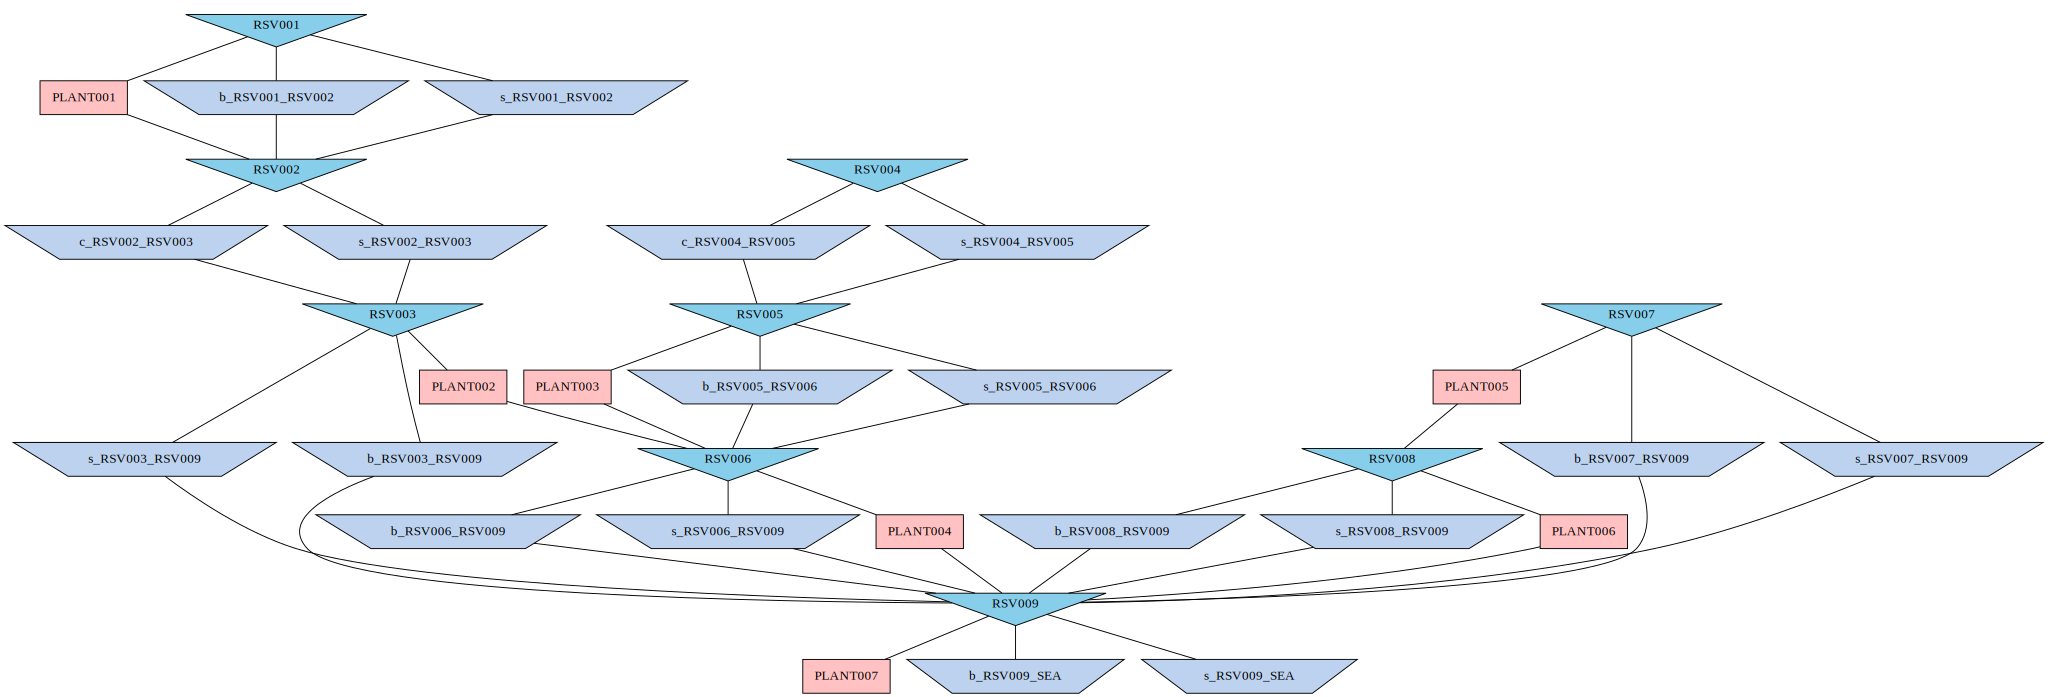

In [2]:
# Create a new SHOP session
shop = ShopSession()
shop.load_yaml("model_maintenance.yaml")
# Print out the topology
shop.model.build_connection_tree()

The price and inflow used in the example is shown below.

In [3]:
# Plot the position of the example on the whole data set
market = shop.model.market["DA"]
spot_price = market.sale_price.get()

res = shop.get_time_resolution()
starttime = res["starttime"]
endtime = res["endtime"]

fig = go.Figure()
fig.add_trace(go.Scatter(x=spot_price.index, y=spot_price.values, marker_color="red",name="Market price"))
fig.update_layout(title="<b>The market price and water values</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Price</b> (EUR/MWh)")

for rsv in shop.model.reservoir: 
    energy_value = rsv.energy_value_input.get()
    fig.add_trace(go.Scatter(x=[starttime, endtime], y=[energy_value, energy_value],name=rsv.get_name(), line=dict(dash="dot")))
fig.show()


fig = go.Figure()
for rsv in shop.model.reservoir: 
    inflow = rsv.inflow.get()
    fig.add_trace(go.Scatter(x=inflow.index, y=inflow.values, name=rsv.get_name()))

fig.update_layout(title="<b>The inflow to reservoirs</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Inflow</b> (m<sup>3</sup>/s)")
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))
fig.show()

## Run the optimization model

First we run the original model without maintenance:

In [4]:
# Set default run commands
def run_model(shop):       
    shop.start_sim([], ["3"])       
    shop.set_code(["incremental"], [])    
    shop.start_sim([], ["3"])
    objective_value=-shop.model.objective["average_objective"].grand_total.get()
    return objective_value
      

# Call the run
objective_orig = run_model(shop)

Then we create a fresh SHOP run where G1 in PLANT004 is set to be on maintenance for the whole period and compare the objective values.

In [5]:
shop_m = ShopSession()
shop_m.load_yaml("model_maintenance.yaml")
shop_m.model.generator["PLANT004_G1"].maintenance_flag.set(1)    

# Call the run
objective_m = run_model(shop_m)

print(f"The cost of maintenance is {objective_orig-objective_m:.2f} €")

The cost of maintenance is 8008.31 €


We see that the amount of energy sold in the market is lower when the generator is on maintenance, and the hydropower producer is unable to fully utilize the highest price periods.

In [6]:
# Plot final result: market sale and buy
sale_orig = market.sale.get()
sale_m = shop_m.model.market["DA"].sale.get()

fig = go.Figure()  
fig.add_trace(go.Scatter(x=sale_orig.index, y=-sale_orig.values, name="Sale, original"))
fig.add_trace(go.Scatter(x=sale_m.index, y=-sale_m.values, name="Sale, maintenance"))
fig.update_layout(title="<b>Energy sold in the market </b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Electricity</b> (MW)")
fig.show()

The reservoir trajectories are also impacted by the generator on maintenance:

In [7]:
# Plot final result: reservoir traject 
for rsv in shop.model.reservoir: 
    name = rsv.get_name()
    storage=rsv.storage.get()
    max_vol = rsv.max_vol.get()
    
    rsv_m = shop_m.model.reservoir[name]
    storage_m = rsv_m.storage.get()
    
    fig = go.Figure()  
    title_name="<b>Reservoir traject of "+name+"</b>"
    fig.add_trace(go.Scatter(x=storage.index, y=storage.values, name="Reservoir storage, original"))
    fig.add_trace(go.Scatter(x=storage_m.index, y=storage_m.values, name="Reservoir storage, maintenance"))
    fig.add_trace(go.Scatter(x=[starttime,endtime], y=[max_vol,max_vol], name="Reservoir max_volume")) 
    fig.update_layout(title=title_name, xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Volume</b> (Mm<sup>3</sup>)")
    fig.show()

The generator production in both the original and maintenance case are shown below.

In [8]:
# Plot final result: generator production 
fig = make_subplots(specs=[[{"secondary_y": True}]])
max_production = 0
for gen in shop.model.generator: 
    name=gen.get_name()
    gen_production=gen.production.get()  
    fig.add_trace(go.Bar(x=gen_production.index, y=gen_production.values, name=name), secondary_y=False)    
    max_production = max_production + np.max(gen_production)
    
spot_price=market.sale_price.get()
fig.add_trace(go.Scatter(x=spot_price.index, y=spot_price.values, name="Market price", marker_color="red"), secondary_y=True)
fig.update_layout(title_text="<b>Generator production - Original </b>", barmode="stack", colorway=px.colors.qualitative.Light24)
fig.update_xaxes(title_text="<b>Time</b> (Hour)")
fig.update_yaxes(title_text="<b>Price<b>", secondary_y=True)
fig.update_yaxes(title_text="<b>Production<b>", secondary_y=False)
fig.show()

fig = make_subplots(specs=[[{"secondary_y": True}]])
max_production = 0
for gen in shop_m.model.generator: 
    name=gen.get_name()
    gen_production=gen.production.get()  
    fig.add_trace(go.Bar(x=gen_production.index, y=gen_production.values, name=name), secondary_y=False)    
    max_production = max_production + np.max(gen_production)
    
fig.add_trace(go.Scatter(x=spot_price.index, y=spot_price.values, name="Market price", marker_color="red"), secondary_y=True)
fig.update_layout(title_text="<b>Generator production - Maintenance </b>", barmode="stack", colorway=px.colors.qualitative.Light24)
fig.update_xaxes(title_text="<b>Time</b> (Hour)")
fig.update_yaxes(title_text="<b>Price<b>", secondary_y=True)
fig.update_yaxes(title_text="<b>Production<b>", secondary_y=False)
fig.show()